In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [3]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=10

In [4]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "RealDataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE)

Found 3495 files belonging to 4 classes.


In [5]:
class_names=dataset.class_names

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 0, 1, 0, 2, 1, 1, 2, 1, 2, 0, 1, 0, 0, 3, 1, 0, 0, 2, 0, 3, 0,
       3, 3, 2, 2, 2, 1, 3, 0, 1, 1])>>


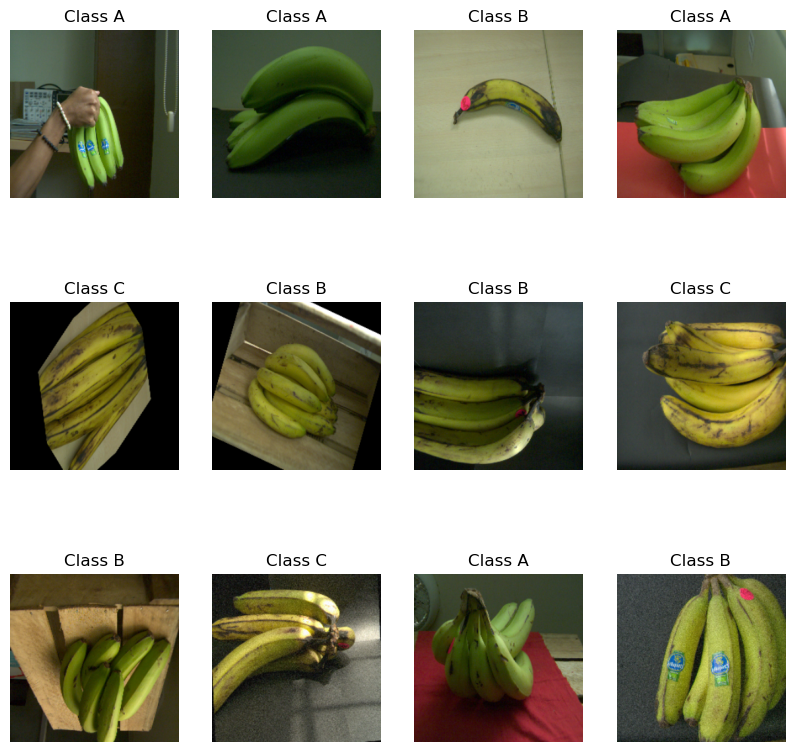

In [6]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy)
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partition(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    assert(train_split+val_split+test_split)==1
    
    ds_size=len(ds)
    print(ds_size)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [8]:
 train_ds,val_ds,test_ds=get_dataset_partition(dataset)

110


In [9]:
len(val_ds)

11

In [10]:
len(test_ds)

11

In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.45882353 0.4        0.19215687]
  [0.5384804  0.48284313 0.2495098 ]
  [0.45710784 0.40220588 0.19264705]
  ...
  [0.22083333 0.24779412 0.16470589]
  [0.1        0.14019608 0.08504902]
  [0.1254902  0.15294118 0.11372549]]

 [[0.4875     0.43186274 0.22720589]
  [0.49984682 0.42668504 0.22501531]
  [0.45989582 0.37611827 0.19165134]
  ...
  [0.19355085 0.2065717  0.14518996]
  [0.18941483 0.21885723 0.171875  ]
  [0.16053921 0.17205882 0.1487745 ]]

 [[0.5776961  0.5012255  0.31887254]
  [0.3992647  0.32677695 0.13426776]
  [0.42666972 0.35257354 0.16007966]
  ...
  [0.22432598 0.22890624 0.18180147]
  [0.21662071 0.2132506  0.15753676]
  [0.20367648 0.225      0.1487745 ]]

 ...

 [[0.2245098  0.16078432 0.01985294]
  [0.3009804  0.21156557 0.07421875]
  [0.30177698 0.22092524 0.07581189]
  ...
  [0.2541054  0.21000306 0.04587929]
  [0.26992953 0.23048407 0.07378983]
  [0.3764706  0.3009804  0.17794117]]

 [[0.29828432 0.21936275 0.08137255]
  [0.31600797 0.2512255  0.10188419]


In [13]:
resize_and_rescale = tf.keras.Sequential([
     layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
     layers.experimental.preprocessing.Rescaling(1.0/255)
                                       ])

In [14]:
data_argumentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=4
model=models.Sequential([
    resize_and_rescale,
    data_argumentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])
model.build(input_shape)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [17]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']

)

In [18]:
history=model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1,epochs=EPOCHS)

Epoch 1/10
88/88 [==============================] - 198s 2s/step - loss: 0.8428 - accuracy: 0.6113 - val_loss: 0.3825 - val_accuracy: 0.8352
Epoch 2/10
88/88 [==============================] - 159s 2s/step - loss: 0.4848 - accuracy: 0.7900 - val_loss: 0.3763 - val_accuracy: 0.8324
Epoch 3/10
88/88 [==============================] - 159s 2s/step - loss: 0.3963 - accuracy: 0.8323 - val_loss: 0.2908 - val_accuracy: 0.8636
Epoch 4/10
88/88 [==============================] - 157s 2s/step - loss: 0.4243 - accuracy: 0.8295 - val_loss: 0.2597 - val_accuracy: 0.8949
Epoch 5/10
88/88 [==============================] - 157s 2s/step - loss: 0.3259 - accuracy: 0.8685 - val_loss: 0.3678 - val_accuracy: 0.8608
Epoch 6/10
88/88 [==============================] - 171s 2s/step - loss: 0.3255 - accuracy: 0.8681 - val_loss: 0.2505 - val_accuracy: 0.9034
Epoch 7/10
88/88 [==============================] - 181s 2s/step - loss: 0.2934 - accuracy: 0.8832 - val_loss: 0.2649 - val_accuracy: 0.9006
Epoch 8/10
88

In [19]:
scores=model.evaluate(test_ds)

11/11 [==============================] - 17s 548ms/step - loss: 0.2357 - accuracy: 0.9062


Image to be predict
Actual label Class C
1/1 [==============================] - 0s 374ms/step
Predictaed label Class C


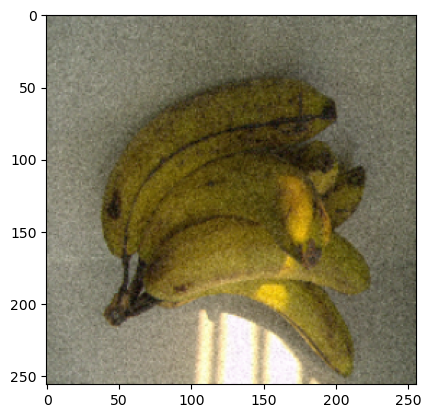

In [21]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("Image to be predict")
    plt.imshow(first_image)
    print("Actual label",class_names[labels_batch[0].numpy()])
    batch_prediction = model.predict(images_batch)
    print("Predictaed label",class_names[np.argmax(batch_prediction[0])])